In [108]:
import pandas as pd
import numpy as np
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from netaddr import IPNetwork, IPAddress

In [109]:
df = pd.read_csv("all-traffic.csv")

In [110]:
proto_counts = df['Protocol'].value_counts()
print(proto_counts)

UDP         3598
TCP          643
SIP          596
HTTP         122
STUN          44
DTLSv1.2      19
Name: Protocol, dtype: int64


In [111]:
IPs = list(df['Source'].unique())
IPs.sort()
IPs = list(map(IPAddress, IPs))
UE_IPs = [ip for ip in IPs if ip in IPNetwork('192.168.20.0/24')]
UE_IPs


[IPAddress('192.168.20.2'),
 IPAddress('192.168.20.3'),
 IPAddress('192.168.20.4')]

In [112]:
new_df = pd.DataFrame(columns=['Time','UE-App','Length'])

for i, row in df.iterrows():
    
    
    if '192.168.3.101' in row['Source'] or '192.168.3.101' in row['Destination']:
        app = 'web-rtc'
    
    if '192.168.3.102' in row['Source'] or '192.168.3.102' in row['Destination']:
        app = 'sipp'
        
    if '192.168.3.103' in row['Source'] or '192.168.3.103' in row['Destination']:
        app = 'web-server'
        
    if  str(UE_IPs[0]) in row['Source'] or str(UE_IPs[0]) in row['Destination']:
        ue = '1'
        
    if str(UE_IPs[1]) in row['Source'] or str(UE_IPs[1]) in row['Destination']:
        ue = '2'
        
    if str(UE_IPs[2]) in row['Source'] or str(UE_IPs[2]) in row['Destination']:
        ue = '3'
       
    data = {'Time': [row['Time']], 'UE-App':["UE"+str(ue) + ": " + app], 'Length':[row['Length']]}
    temp_df = pd.DataFrame.from_dict(data)
    
    
    new_df = new_df.append(temp_df, ignore_index=True)

In [66]:
new_df

,Time,UE-App,Length
0,31.530196,UE1: web-rtc,74
1,31.530218,UE1: web-rtc,74
2,31.530228,UE1: web-rtc,74
3,31.530238,UE1: web-rtc,74
4,31.530248,UE1: web-rtc,74
...,...,...,...
5017,51.162078,UE1: web-rtc,66
5018,52.106807,UE1: web-rtc,66
5019,52.161047,UE1: web-rtc,66
5020,55.992120,UE1: web-rtc,66


(array([100., 324., 628., 798., 836., 752., 784., 790.,   8.,   2.]),
 array([31.530196 , 33.9764081, 36.4226202, 38.8688323, 41.3150444,
        43.7612565, 46.2074686, 48.6536807, 51.0998928, 53.5461049,
        55.992317 ]),
 <BarContainer object of 10 artists>)

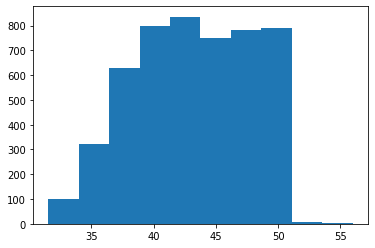

In [67]:
plt.hist(new_df['Time'])

  # Based on the sum of lengths of packets in a window

# Time Sequence Aware

### Mini Windows

In [68]:
def make_mini_windows2(new_df, offset = 0,duration=1):

    '''Finds the beggining indexes for each window'''
    X_dict = { }
    X_dict['UE1'] = {}
    X_dict['UE1']['web-rtc'] = []
    X_dict['UE1']['sipp'] = []
    X_dict['UE1']['web-server'] = []
    X_dict['UE2'] = {}
    X_dict['UE2']['web-rtc'] = []
    X_dict['UE2']['sipp'] = []
    X_dict['UE2']['web-server'] = []
    X_dict['UE3'] = {}
    X_dict['UE3']['web-rtc'] = []
    X_dict['UE3']['sipp'] = []
    X_dict['UE3']['web-server'] = []
    
    time_start = -1 
    for i, row in new_df.iloc[offset:,:].iterrows():

        if time_start == -1:
            time_start = row['Time']
            index_start = i

        time_end = row['Time']

        # check elapsed time
        if time_end - time_start >= duration:
            time_start = -1
            index_end = i

            # crop window
            window = new_df.iloc[index_start:index_end+1,:]
            
            length_sum = dict(window.groupby('UE-App')['Length'].sum())
            window_combs = list(window['UE-App'].unique())


            for key, value in X_dict.items():
                for j in list(X_dict[key].keys()):
                    comb = str(key) + ": " + str(j)
                    if comb in window_combs:
                        X_dict[key][str(j)].append(length_sum[comb])
                    else:
                        X_dict[key][str(j)].append(0)
            
                            
            
    return X_dict

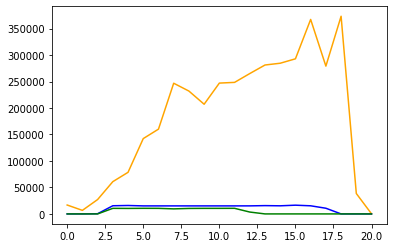

In [69]:
X_dict = make_mini_windows2(new_df, offset = 0, duration=1)
plt.figure()
plt.plot(X_dict["UE1"]["web-rtc"],color='orange')
plt.plot(X_dict["UE2"]["sipp"], color ='blue')
plt.plot(X_dict["UE3"]["web-server"], color='green')
plt.show()

In [70]:
def extract_x(X_dict, window=4,y_window=2):
    X = { }
    X['UE1'] = {}
    X['UE1']['web-rtc'] = []
    X['UE1']['sipp'] = []
    X['UE1']['web-server'] = []
    X['UE2'] = {}
    X['UE2']['web-rtc'] = []
    X['UE2']['sipp'] = []
    X['UE2']['web-server'] = []
    X['UE3'] = {}
    X['UE3']['web-rtc'] = []
    X['UE3']['sipp'] = []
    X['UE3']['web-server'] = []

    for (k,v), (k2,v2) in zip(X.items(), X_dict.items()):
                if k == k2:
                    for value in list(X_dict[k].keys()):
                        for i in range(len(X_dict[k][value])):
                            if i >= len(X_dict[k][value]) - (window-1) - y_window:
                                break
                            X[k][value].append((X_dict[k][value][i:i+window]))
    return X

In [71]:
X = extract_x(X_dict, window=4)           
X

{'UE1': {'web-rtc': [[16809, 6708, 27134, 60932],
   [6708, 27134, 60932, 78566],
   [27134, 60932, 78566, 142265],
   [60932, 78566, 142265, 160126],
   [78566, 142265, 160126, 246804],
   [142265, 160126, 246804, 232010],
   [160126, 246804, 232010, 207136],
   [246804, 232010, 207136, 247070],
   [232010, 207136, 247070, 248409],
   [207136, 247070, 248409, 265090],
   [247070, 248409, 265090, 281224],
   [248409, 265090, 281224, 284573],
   [265090, 281224, 284573, 292926],
   [281224, 284573, 292926, 367289],
   [284573, 292926, 367289, 279121],
   [292926, 367289, 279121, 373314]],
  'sipp': [[0, 0, 0, 0],
   [0, 0, 0, 0],
   [0, 0, 0, 0],
   [0, 0, 0, 0],
   [0, 0, 0, 0],
   [0, 0, 0, 0],
   [0, 0, 0, 0],
   [0, 0, 0, 0],
   [0, 0, 0, 0],
   [0, 0, 0, 0],
   [0, 0, 0, 0],
   [0, 0, 0, 0],
   [0, 0, 0, 0],
   [0, 0, 0, 0],
   [0, 0, 0, 0],
   [0, 0, 0, 0]],
  'web-server': [[0, 0, 0, 0],
   [0, 0, 0, 0],
   [0, 0, 0, 0],
   [0, 0, 0, 0],
   [0, 0, 0, 0],
   [0, 0, 0, 0],
   [0, 0

In [72]:
def extract_y(X_dict, X, window=3, y_window=2):
    Y = { }
    Y['UE1'] = {}
    Y['UE1']['web-rtc'] = []
    Y['UE1']['sipp'] = []
    Y['UE1']['web-server'] = []
    Y['UE2'] = {}
    Y['UE2']['web-rtc'] = []
    Y['UE2']['sipp'] = []
    Y['UE2']['web-server'] = []
    Y['UE3'] = {}
    Y['UE3']['web-rtc'] = []
    Y['UE3']['sipp'] = []
    Y['UE3']['web-server'] = []

    for (k,v), (k2,v2) in zip(Y.items(), X_dict.items()):
                if k == k2:
                    for value in list(X_dict[k].keys()):
                        for i in range(len(X['UE1']['web-rtc'])):
                            if i >= len(X_dict[k][value]) - (window-1) - y_window:
                                break
                            Y[k][value].append(np.mean(X_dict[k][value][window+i:window+y_window+i]))
                       
    return Y

In [73]:
Y = extract_y(X_dict, X, window=4, y_window=2)           
Y

{'UE1': {'web-rtc': [110415.5,
   151195.5,
   203465.0,
   239407.0,
   219573.0,
   227103.0,
   247739.5,
   256749.5,
   273157.0,
   282898.5,
   288749.5,
   330107.5,
   323205.0,
   326217.5,
   205926.0,
   19335.0],
  'sipp': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  'web-server': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0]},
 'UE2': {'web-rtc': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  'sipp': [15537.0,
   15160.0,
   15160.0,
   15160.0,
   15160.0,
   15160.0,
   15160.0,
   15176.0,
   15436.0,
   15500.0,
   15906.0,
   15906.0,
   13022.0,
   5362.0,
   0.0,
   0.0],
  'web-server': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0]},
 'UE3': {'

In [74]:
def array_x(X):
    iters = len(X['UE1']['web-rtc'])
    X_list = []
    for i in range(iters):
        temp_list = []
        for ue, stats in X.items():
            #print(ue)
            for app, values in stats.items():
                #print(app, values[i])
                temp_list.append(values[i])

        # edw exeis parei oli tin seira
        X_list.append(temp_list)
    
    return X_list    

    

In [75]:
X_list = array_x(X)

In [76]:
X_list[0]

[[16809, 6708, 27134, 60932],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 352, 15426],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 10512]]

In [78]:
def array_y(Y):
    iters = len(Y['UE1']['web-rtc'])
    y_list = []
    for i in range(iters):
        temp_list = []
        for ue, stats in Y.items():
            #print(ue)
            for app, values in stats.items():
                temp_list.append(values[i])

        # edw exeis parei oli tin seira
        y_list.append([temp_list])
    
    return y_list

In [79]:
Y

{'UE1': {'web-rtc': [110415.5,
   151195.5,
   203465.0,
   239407.0,
   219573.0,
   227103.0,
   247739.5,
   256749.5,
   273157.0,
   282898.5,
   288749.5,
   330107.5,
   323205.0,
   326217.5,
   205926.0,
   19335.0],
  'sipp': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  'web-server': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0]},
 'UE2': {'web-rtc': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  'sipp': [15537.0,
   15160.0,
   15160.0,
   15160.0,
   15160.0,
   15160.0,
   15160.0,
   15176.0,
   15436.0,
   15500.0,
   15906.0,
   15906.0,
   13022.0,
   5362.0,
   0.0,
   0.0],
  'web-server': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0]},
 'UE3': {'

In [80]:
y_list = array_y(Y)

In [81]:
X_list[0]

[[16809, 6708, 27134, 60932],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 352, 15426],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 10512]]

In [82]:
y_list[0]

[[110415.5, 0.0, 0.0, 0.0, 15537.0, 0.0, 0.0, 0.0, 10479.0]]

In [83]:
X_list

[[[16809, 6708, 27134, 60932],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 0, 352, 15426],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 0, 0, 10512]],
 [[6708, 27134, 60932, 78566],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 352, 15426, 15914],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 0, 10512, 10380]],
 [[27134, 60932, 78566, 142265],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [352, 15426, 15914, 15160],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 10512, 10380, 10578]],
 [[60932, 78566, 142265, 160126],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [15426, 15914, 15160, 15160],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [10512, 10380, 10578, 10512]],
 [[78566, 142265, 160126, 246804],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [15914, 15160, 15160, 15160],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [10380, 10578, 10512, 9527]],
 [[142265, 160126, 246804, 232010],
  [0, 0, 0, 0],
  [0, 0, 0, 0],
  [0, 

In [84]:
scaler = MinMaxScaler()

In [85]:
flattened = np.array(X_list).reshape(-1,1)
flattened.shape

(576, 1)

In [95]:
rescaled = scaler.fit_transform(flattened)
X_scaled = rescaled.reshape(16,9,4)
X_scaled.shape

(16, 9, 4)

In [88]:
y_flattened = np.array(y_list).reshape(-1,1)
y_flattened.shape

(144, 1)

In [98]:
y_rescaled = scaler.fit_transform(y_flattened)

In [99]:
y_scaled = y_rescaled.reshape(16,9,1)
y_scaled.shape

(16, 9, 1)

In [91]:
X_final = np.array(X_scaled)

In [92]:
X_final.shape

(16, 9, 4)

In [54]:
y_final = np.array(y_list)

In [96]:
y_final.shape

(16, 1, 9)

In [97]:
y_final

array([[[110415.5,      0. ,      0. ,      0. ,  15537. ,      0. ,
              0. ,      0. ,  10479. ]],

       [[151195.5,      0. ,      0. ,      0. ,  15160. ,      0. ,
              0. ,      0. ,  10545. ]],

       [[203465. ,      0. ,      0. ,      0. ,  15160. ,      0. ,
              0. ,      0. ,  10019.5]],

       [[239407. ,      0. ,      0. ,      0. ,  15160. ,      0. ,
              0. ,      0. ,   9935.5]],

       [[219573. ,      0. ,      0. ,      0. ,  15160. ,      0. ,
              0. ,      0. ,  10424. ]],

       [[227103. ,      0. ,      0. ,      0. ,  15160. ,      0. ,
              0. ,      0. ,  10504. ]],

       [[247739.5,      0. ,      0. ,      0. ,  15160. ,      0. ,
              0. ,      0. ,  10541. ]],

       [[256749.5,      0. ,      0. ,      0. ,  15176. ,      0. ,
              0. ,      0. ,   7052. ]],

       [[273157. ,      0. ,      0. ,      0. ,  15436. ,      0. ,
              0. ,      0. ,   1763. ]],

 

In [93]:
X_final

array([[[4.50264389e-02, 1.79687877e-02, 7.26841211e-02, 1.63219167e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 9.42905972e-04, 4.13217827e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.81586011e-02]],

       [[1.79687877e-02, 7.26841211e-02, 1.63219167e-01, 2.10455541e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.42905972e

In [146]:
# univariate lstm example

In [101]:
model = Sequential()
model.add(LSTM(50, activation='relu',  return_sequences=True, input_shape=(9, 4)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(9))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 9, 50)             11000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 9)                 459       
Total params: 31,659
Trainable params: 31,659
Non-trainable params: 0
_________________________________________________________________


In [102]:
model.fit(X_scaled,y_scaled,epochs=10000)

Epoch 1/10000
1/1 [==============================] - 3s 3s/step - loss: 0.0620
Epoch 2/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.0610
Epoch 3/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.0601
Epoch 4/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.0592
Epoch 5/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.0583
Epoch 6/10000
1/1 [==============================] - 0s 11ms/step - loss: 0.0574
Epoch 7/10000
1/1 [==============================] - 0s 11ms/step - loss: 0.0564
Epoch 8/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.0553
Epoch 9/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.0542
Epoch 10/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.0530
Epoch 11/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.0517
Epoch 12/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.0503
Epoch 13/10000
1/1 [=======

1/1 [==============================] - 0s 17ms/step - loss: 0.0058
Epoch 102/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.0058
Epoch 103/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.0058
Epoch 104/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.0058
Epoch 105/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.0058
Epoch 106/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.0057
Epoch 107/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.0057
Epoch 108/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.0057
Epoch 109/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.0057
Epoch 110/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.0057
Epoch 111/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.0057
Epoch 112/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.0057
Epoch 113/10000
1/1 

1/1 [==============================] - 0s 10ms/step - loss: 0.0055
Epoch 201/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.0055
Epoch 202/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.0055
Epoch 203/10000
1/1 [==============================] - 0s 9ms/step - loss: 0.0055
Epoch 204/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.0055
Epoch 205/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.0055
Epoch 206/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.0055
Epoch 207/10000
1/1 [==============================] - 0s 11ms/step - loss: 0.0055
Epoch 208/10000
1/1 [==============================] - 0s 11ms/step - loss: 0.0055
Epoch 209/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.0055
Epoch 210/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.0055
Epoch 211/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.0055
Epoch 212/10000
1/1 [=

Epoch 299/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.0049
Epoch 300/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.0049
Epoch 301/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.0049
Epoch 302/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.0049
Epoch 303/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.0049
Epoch 304/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.0048
Epoch 305/10000
1/1 [==============================] - 0s 9ms/step - loss: 0.0048
Epoch 306/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.0048
Epoch 307/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.0048
Epoch 308/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.0047
Epoch 309/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.0047
Epoch 310/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.0047
Epoch

1/1 [==============================] - 0s 17ms/step - loss: 0.0014
Epoch 398/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.0014
Epoch 399/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.0014
Epoch 400/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.0014
Epoch 401/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 402/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.0014
Epoch 403/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.0014
Epoch 404/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.0014
Epoch 405/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.0014
Epoch 406/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.0014
Epoch 407/10000
1/1 [==============================] - 0s 18ms/step - loss: 0.0014
Epoch 408/10000
1/1 [==============================] - 0s 16ms/step - loss: 0.0014
Epoch 409/10000
1/1 [

Epoch 496/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.0010
Epoch 497/10000
1/1 [==============================] - 0s 22ms/step - loss: 0.0010
Epoch 498/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.0010
Epoch 499/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.0010
Epoch 500/10000
1/1 [==============================] - 0s 17ms/step - loss: 0.0010
Epoch 501/10000
1/1 [==============================] - 0s 11ms/step - loss: 0.0010
Epoch 502/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.0010
Epoch 503/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.0010
Epoch 504/10000
1/1 [==============================] - 0s 13ms/step - loss: 0.0010
Epoch 505/10000
1/1 [==============================] - 0s 15ms/step - loss: 0.0010
Epoch 506/10000
1/1 [==============================] - 0s 23ms/step - loss: 0.0010
Epoch 507/10000
1/1 [==============================] - 0s 21ms/step - loss: 9.9923e-04


1/1 [==============================] - 0s 15ms/step - loss: 3.6936e-04
Epoch 591/10000
1/1 [==============================] - 0s 14ms/step - loss: 3.6848e-04
Epoch 592/10000
1/1 [==============================] - 0s 17ms/step - loss: 3.5455e-04
Epoch 593/10000
1/1 [==============================] - 0s 16ms/step - loss: 3.5327e-04
Epoch 594/10000
1/1 [==============================] - 0s 11ms/step - loss: 3.5243e-04
Epoch 595/10000
1/1 [==============================] - 0s 14ms/step - loss: 3.4293e-04
Epoch 596/10000
1/1 [==============================] - 0s 10ms/step - loss: 3.3916e-04
Epoch 597/10000
1/1 [==============================] - 0s 14ms/step - loss: 3.3693e-04
Epoch 598/10000
1/1 [==============================] - 0s 13ms/step - loss: 3.2995e-04
Epoch 599/10000
1/1 [==============================] - 0s 13ms/step - loss: 3.2316e-04
Epoch 600/10000
1/1 [==============================] - 0s 13ms/step - loss: 3.1317e-04
Epoch 601/10000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 9ms/step - loss: 1.2651e-04
Epoch 685/10000
1/1 [==============================] - 0s 12ms/step - loss: 1.2656e-04
Epoch 686/10000
1/1 [==============================] - 0s 13ms/step - loss: 1.1227e-04
Epoch 687/10000
1/1 [==============================] - 0s 12ms/step - loss: 1.3396e-04
Epoch 688/10000
1/1 [==============================] - 0s 12ms/step - loss: 1.1705e-04
Epoch 689/10000
1/1 [==============================] - 0s 13ms/step - loss: 1.2053e-04
Epoch 690/10000
1/1 [==============================] - 0s 11ms/step - loss: 1.1856e-04
Epoch 691/10000
1/1 [==============================] - 0s 9ms/step - loss: 1.1064e-04
Epoch 692/10000
1/1 [==============================] - 0s 12ms/step - loss: 1.1863e-04
Epoch 693/10000
1/1 [==============================] - 0s 14ms/step - loss: 1.0891e-04
Epoch 694/10000
1/1 [==============================] - 0s 16ms/step - loss: 1.1869e-04
Epoch 695/10000
1/1 [==============================] - 0s 15m

1/1 [==============================] - 0s 12ms/step - loss: 8.6911e-05
Epoch 779/10000
1/1 [==============================] - 0s 11ms/step - loss: 8.6077e-05
Epoch 780/10000
1/1 [==============================] - 0s 12ms/step - loss: 8.6248e-05
Epoch 781/10000
1/1 [==============================] - 0s 13ms/step - loss: 8.6332e-05
Epoch 782/10000
1/1 [==============================] - 0s 12ms/step - loss: 8.6745e-05
Epoch 783/10000
1/1 [==============================] - 0s 10ms/step - loss: 8.5643e-05
Epoch 784/10000
1/1 [==============================] - 0s 15ms/step - loss: 8.6042e-05
Epoch 785/10000
1/1 [==============================] - 0s 13ms/step - loss: 8.5766e-05
Epoch 786/10000
1/1 [==============================] - 0s 12ms/step - loss: 8.4802e-05
Epoch 787/10000
1/1 [==============================] - 0s 12ms/step - loss: 8.5566e-05
Epoch 788/10000
1/1 [==============================] - 0s 11ms/step - loss: 8.4414e-05
Epoch 789/10000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 22ms/step - loss: 1.0626e-04
Epoch 873/10000
1/1 [==============================] - 0s 19ms/step - loss: 8.0020e-05
Epoch 874/10000
1/1 [==============================] - 0s 14ms/step - loss: 1.0736e-04
Epoch 875/10000
1/1 [==============================] - 0s 15ms/step - loss: 8.2493e-05
Epoch 876/10000
1/1 [==============================] - 0s 11ms/step - loss: 9.4086e-05
Epoch 877/10000
1/1 [==============================] - 0s 16ms/step - loss: 8.0733e-05
Epoch 878/10000
1/1 [==============================] - 0s 17ms/step - loss: 8.4484e-05
Epoch 879/10000
1/1 [==============================] - 0s 11ms/step - loss: 8.8388e-05
Epoch 880/10000
1/1 [==============================] - 0s 9ms/step - loss: 8.3130e-05
Epoch 881/10000
1/1 [==============================] - 0s 13ms/step - loss: 9.0467e-05
Epoch 882/10000
1/1 [==============================] - 0s 11ms/step - loss: 7.7249e-05
Epoch 883/10000
1/1 [==============================] - 0s 12

1/1 [==============================] - 0s 13ms/step - loss: 6.0287e-05
Epoch 967/10000
1/1 [==============================] - 0s 12ms/step - loss: 5.9986e-05
Epoch 968/10000
1/1 [==============================] - 0s 13ms/step - loss: 5.9779e-05
Epoch 969/10000
1/1 [==============================] - 0s 14ms/step - loss: 5.9966e-05
Epoch 970/10000
1/1 [==============================] - 0s 12ms/step - loss: 5.9986e-05
Epoch 971/10000
1/1 [==============================] - 0s 15ms/step - loss: 6.0077e-05
Epoch 972/10000
1/1 [==============================] - 0s 15ms/step - loss: 5.9756e-05
Epoch 973/10000
1/1 [==============================] - 0s 10ms/step - loss: 5.9333e-05
Epoch 974/10000
1/1 [==============================] - 0s 12ms/step - loss: 5.9211e-05
Epoch 975/10000
1/1 [==============================] - 0s 13ms/step - loss: 5.9112e-05
Epoch 976/10000
1/1 [==============================] - 0s 11ms/step - loss: 5.9296e-05
Epoch 977/10000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 10ms/step - loss: 5.2892e-05
Epoch 1060/10000
1/1 [==============================] - 0s 12ms/step - loss: 5.3223e-05
Epoch 1061/10000
1/1 [==============================] - 0s 13ms/step - loss: 5.3165e-05
Epoch 1062/10000
1/1 [==============================] - 0s 11ms/step - loss: 5.2454e-05
Epoch 1063/10000
1/1 [==============================] - 0s 15ms/step - loss: 5.2084e-05
Epoch 1064/10000
1/1 [==============================] - 0s 9ms/step - loss: 5.2506e-05
Epoch 1065/10000
1/1 [==============================] - 0s 9ms/step - loss: 5.2955e-05
Epoch 1066/10000
1/1 [==============================] - 0s 12ms/step - loss: 5.2684e-05
Epoch 1067/10000
1/1 [==============================] - 0s 11ms/step - loss: 5.2414e-05
Epoch 1068/10000
1/1 [==============================] - 0s 10ms/step - loss: 5.2170e-05
Epoch 1069/10000
1/1 [==============================] - 0s 15ms/step - loss: 5.1734e-05
Epoch 1070/10000
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 4.7327e-05
Epoch 1153/10000
1/1 [==============================] - 0s 13ms/step - loss: 4.7820e-05
Epoch 1154/10000
1/1 [==============================] - 0s 11ms/step - loss: 4.8299e-05
Epoch 1155/10000
1/1 [==============================] - 0s 22ms/step - loss: 4.6172e-05
Epoch 1156/10000
1/1 [==============================] - 0s 12ms/step - loss: 4.6611e-05
Epoch 1157/10000
1/1 [==============================] - 0s 10ms/step - loss: 4.8149e-05
Epoch 1158/10000
1/1 [==============================] - 0s 15ms/step - loss: 5.1218e-05
Epoch 1159/10000
1/1 [==============================] - 0s 14ms/step - loss: 5.7027e-05
Epoch 1160/10000
1/1 [==============================] - 0s 11ms/step - loss: 5.0577e-05
Epoch 1161/10000
1/1 [==============================] - 0s 12ms/step - loss: 4.7845e-05
Epoch 1162/10000
1/1 [==============================] - 0s 13ms/step - loss: 4.6923e-05
Epoch 1163/10000
1/1 [===========================

KeyboardInterrupt: 

In [103]:
X_final[0].reshape(1,9,4)

array([[[0.04502644, 0.01796879, 0.07268412, 0.16321917],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.00094291, 0.04132178],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.0281586 ]]])

In [104]:
model.predict(X_scaled[0].reshape(1,9,4))

array([[ 3.3388239e-01,  2.0435080e-05, -9.1757625e-05,  6.7268105e-05,
         4.4214118e-02,  3.8321596e-05,  4.0393323e-05, -4.4581300e-04,
         3.0967971e-02]], dtype=float32)

In [105]:
y_scaled[0]

array([[0.33448346],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.04706649],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.0317442 ]])